In [1]:
import pandas as pd 
import numpy as np
import tableone

In [3]:
df = pd.read_csv('data_light/clean/max_30_authors.csv')

# groupby paper_id and count the number of authors
df['num_authors'] = df.groupby('pub_id')['researcher_id'].transform('count')
# create a column for the author position
df['author_position'] = df.groupby('pub_id')['researcher_id'].transform(lambda x: x.rank(method='first'))
# create a column for the author is first author
df['is_first_author'] = df['author_position'] == 1
# create a column for the author is last author
df['is_last_author'] = df['author_position'] == df['num_authors']

df_authors = df.groupby('researcher_id').agg({
    'pub_id': 'count', 
    'is_first_author': 'sum',
    'is_last_author': 'sum',
    'journal': 'nunique',
    'gender': lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan, # the mode
    'LMIC': 'max',
    'aff_country_code': lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan,
}).reset_index()

df_authors.columns = ['researcher_id', 'num_pubs', 'num_first_author', 'num_last_author', 'num_journals',
                      'gender', 'LMIC', 'aff_country_code']

# encode num_first_author and num_last_author as binary, 1 = 1, >1 if 2,3,4,5,....
df_authors['first_author_more_than_once'] = df_authors['num_first_author'].apply(lambda x: 1 if x > 1 else 0)
df_authors['last_author_more_than_once'] = df_authors['num_last_author'].apply(lambda x: 1 if x > 1 else 0)
df_authors['more_than_one_journal'] = df_authors['num_journals'].apply(lambda x: 1 if x > 1 else 0)
df_authors['more_than_one_pub'] = df_authors['num_pubs'].apply(lambda x: 1 if x > 1 else 0)
df_authors['first_author_once'] = df_authors['num_first_author'].apply(lambda x: 1 if x == 1 else 0)
df_authors['last_author_once'] = df_authors['num_last_author'].apply(lambda x: 1 if x == 1 else 0)

# create tableone object
cols = ['gender', 'LMIC', 'first_author_once', 'last_author_once', 'first_author_more_than_once', 'last_author_more_than_once', 'more_than_one_journal', 'more_than_one_pub', 'aff_country_code']
limit = {'first_author_once': 1, 'last_author_once': 1, 'first_author_more_than_once': 1, 'last_author_more_than_once': 1, 'more_than_one_journal': 1, 'more_than_one_pub': 1, 'aff_country_code': 10}
order = {'first_author_once': [1,0], 'last_author_once': [1,0],'first_author_more_than_once': [1,0], 'last_author_more_than_once': [1,0], 'more_than_one_journal': [1,0], 'more_than_one_pub': [1,0]}
         
table1 = tableone.TableOne(df_authors, columns = cols, categorical = cols, limit=limit, order=order)

# print tableone
table1

Missing        Overall
n                                                         162132
gender, n (%)                      female   15848   55364 (37.8)
                                   male             90920 (62.2)
LMIC, n (%)                        0.0       2624  140674 (88.2)
                                   1.0              18834 (11.8)
first_author_once, n (%)           1            0   24216 (14.9)
last_author_once, n (%)            1            0   24412 (15.1)
first_author_more_than_once, n (%) 1            0     8339 (5.1)
last_author_more_than_once, n (%)  1            0     8226 (5.1)
more_than_one_journal, n (%)       1            0   29496 (18.2)
more_than_one_pub, n (%)           1            0   51029 (31.5)
aff_country_code, n (%)            US        2760   55745 (35.0)
                                   GB               27424 (17.2)
                                   CN                 6794 (4.3)
                                   CA                 6656 (4.2)
                                   DE                 6310 (4.0)
                                   FR                 6244 (3.9)
                                   AU                 5352 (3.4)
                                   NL                 5203 (3.3)
                                   IT                 4013 (2.5)
                                   CH                 3173 (2.0)

In [123]:
# create tableone object
cols = ['first_author_once', 'last_author_once','first_author_more_than_once', 'last_author_more_than_once', 'more_than_one_journal', 'more_than_one_pub']
limit = {'first_author_once': 1, 'last_author_once': 1,'first_author_more_than_once': 1, 'last_author_more_than_once': 1, 'more_than_one_journal': 1, 'more_than_one_pub': 1}
order = {'first_author_once': [1,0], 'last_author_once':[1,0],'first_author_more_than_once': [1,0], 'last_author_more_than_once': [1,0], 'more_than_one_journal': [1,0], 'more_than_one_pub': [1,0]}

table2 = tableone.TableOne(df_authors, columns = cols, categorical = cols, limit=limit, order=order,
                           groupby=['LMIC'], pval=True, overall=False, missing=False, smd=True)

# print tableone
table2

Grouped by LMIC                                   
                                                 0.0          1.0 P-Value SMD (0.0,1.0)
n                                             140674        18834                      
first_author_once, n (%)           1    21142 (15.0)  2633 (14.0)  <0.001         0.030
last_author_once, n (%)            1    21245 (15.1)  2708 (14.4)   0.009         0.020
first_author_more_than_once, n (%) 1      7605 (5.4)    717 (3.8)  <0.001         0.076
last_author_more_than_once, n (%)  1      7513 (5.3)    686 (3.6)  <0.001         0.082
more_than_one_journal, n (%)       1    26690 (19.0)  2792 (14.8)  <0.001         0.111
more_than_one_pub, n (%)           1    45638 (32.4)  5244 (27.8)  <0.001         0.100

In [124]:
# encode gender as binary
df_authors['gender'] = df_authors['gender'].map({'female': 1, 'male': 0})

# create tableone object
cols = ['first_author_once', 'last_author_once','first_author_more_than_once', 'last_author_more_than_once', 'more_than_one_journal', 'more_than_one_pub']
limit = {'first_author_once': 1, 'last_author_once': 1,'first_author_more_than_once': 1, 'last_author_more_than_once': 1, 'more_than_one_journal': 1, 'more_than_one_pub': 1}
order = {'first_author_once': [1,0], 'last_author_once':[1,0],'first_author_more_than_once': [1,0], 'last_author_more_than_once': [1,0], 'more_than_one_journal': [1,0], 'more_than_one_pub': [1,0]}
         
table3 = tableone.TableOne(df_authors, columns = cols, categorical = cols, limit=limit, order=order,
                           groupby=['gender'], pval=True, overall=False, missing=False, smd=True)

# print tableone
table3

Grouped by gender                                    
                                                   0.0           1.0 P-Value SMD (0.0,1.0)
n                                                90920         55364                      
first_author_once, n (%)           1      14087 (15.5)   7850 (14.2)  <0.001         0.037
last_author_once, n (%)            1      14257 (15.7)   7936 (14.3)  <0.001         0.038
first_author_more_than_once, n (%) 1        5418 (6.0)    2405 (4.3)  <0.001         0.073
last_author_more_than_once, n (%)  1        5333 (5.9)    2372 (4.3)  <0.001         0.072
more_than_one_journal, n (%)       1      18964 (20.9)   8677 (15.7)  <0.001         0.135
more_than_one_pub, n (%)           1      31213 (34.3)  15948 (28.8)  <0.001         0.119

In [90]:
import pycountry

# read country to continent mapping
df_country_continent = pd.read_csv('data_light/country_to_continent.csv')

# assuming df is your DataFrame and 'country' is the column with 2 letter country codes
df_country_continent['iso3'] = df_country_continent['country'].apply(lambda x: pycountry.countries.get(alpha_2=x).alpha_3)

df_country_continent.to_csv('data_light/country_to_continent.csv', index=False)

# merge country to continent mapping with df_authors
df_authors = df_authors.merge(df_country_continent, left_on='aff_country_code', right_on='country', how='left')


<AxesSubplot:>

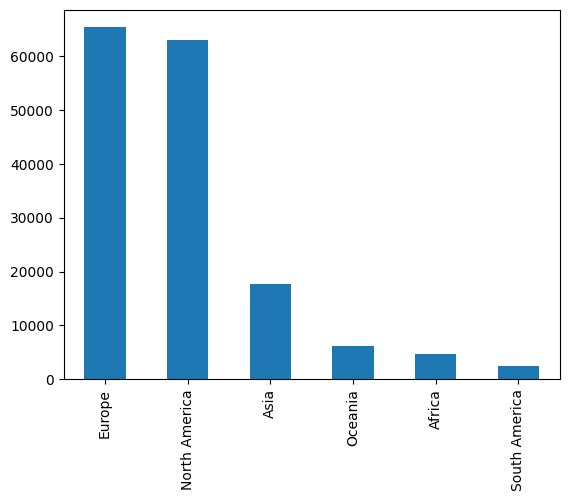

In [91]:
# plot the number of authors by continent
df_authors['continent'].value_counts().plot(kind='bar')


<AxesSubplot:>

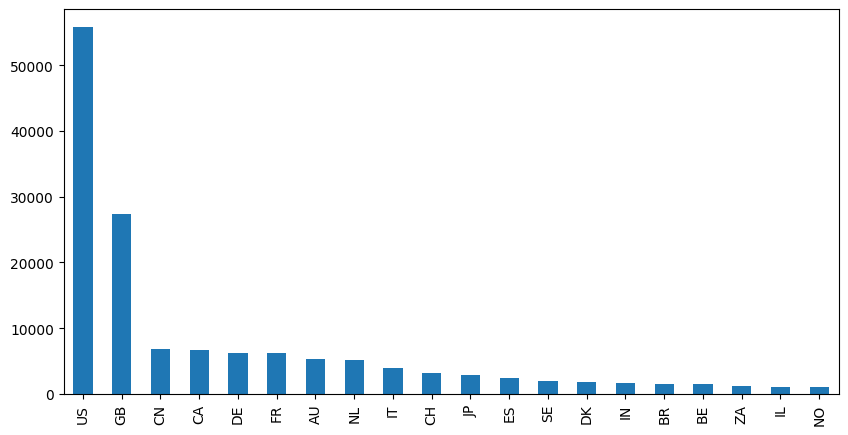

In [92]:
# create a bar plot with top 20 countries, figure size 10x5

df_authors['aff_country_code'].value_counts().head(20).plot(kind='bar', figsize=(10,5))

In [93]:
import geopandas as gpd

# Load the geometries
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Use ISO-ALPHA-2 code as the index (the 2-digit country code)
world.set_index('iso_a3', inplace=True)

author_counts = df_authors.groupby('iso3')['researcher_id'].nunique()
world = world.join(author_counts)


C:\Users\João Matos\AppData\Local\Temp\ipykernel_18944\1722611240.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


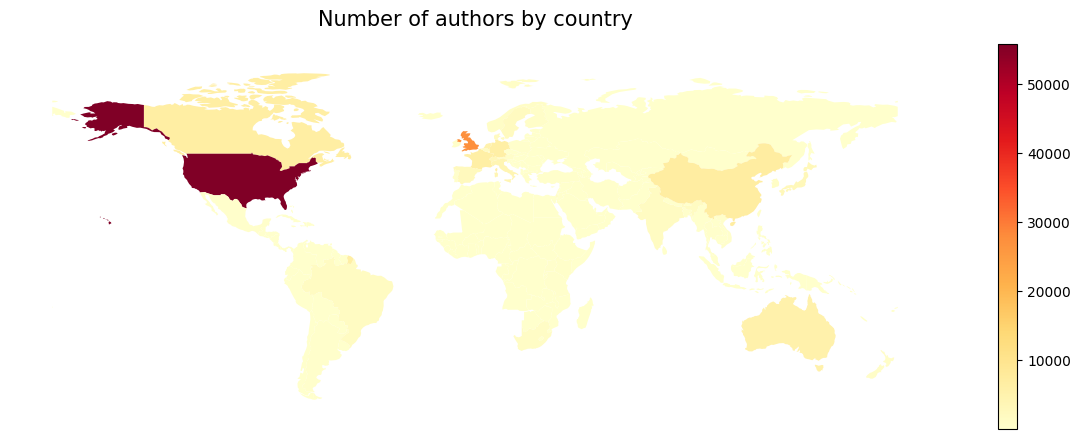

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
world.plot(column='researcher_id', ax=ax, legend=True, cmap='YlOrRd')
ax.set_title('Number of authors by country\n', fontsize=15)
ax.set_axis_off()
plt.show()
